In [1]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
from pyrosm import OSM
from scipy.stats import entropy
import matplotlib.pyplot as plt
import warnings
import shapely

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# FILES
PBF_FILES = {
    "Rotterdam": "zuid-holland-260112.osm.pbf",
    "Utrecht": "utrecht-260108.osm.pbf"
}


# 1. GET NEIGHBOURHOODS
def get_city_neighbourhoods(city_name, country="Netherlands"):
    city_gdf = ox.geocode_to_gdf(f"{city_name}, {country}")
    city_geom = city_gdf.geometry.iloc[0]
    tags = {"place": ["suburb"]}
    areas = ox.features_from_polygon(city_geom, tags)
    areas = areas[
        (areas.geometry.type.isin(["Polygon", "MultiPolygon"])) &
        (areas["name"].notna()) &
        (areas.within(city_geom))
    ].copy()
    areas["city"] = city_name
    return areas[["name", "geometry", "city"]].reset_index(drop=True)

def get_city_boundary(city_name, country="Netherlands"):
    city_gdf = ox.geocode_to_gdf(f"{city_name}, {country}")
    city_gdf["city"] = city_name
    return city_gdf[["city", "geometry"]]




def add_missing_rotterdam_area(rotterdam_gdf, country="Netherlands"):
    # 1. Get full Rotterdam city boundary
    city_gdf = ox.geocode_to_gdf(f"Rotterdam, {country}")
    
    # 2. Project for accurate geometry math
    city_gdf = city_gdf.to_crs(epsg=28992)
    rotterdam_gdf = rotterdam_gdf.to_crs(epsg=28992)

    city_geom = city_gdf.geometry.iloc[0]
    covered_geom = rotterdam_gdf.geometry.unary_union

    # 3. Compute missing area
    missing_geom = city_geom.difference(covered_geom)
    
    # 4. Convert the missing geometry into a GeoDataFrame
    # This might be a MultiPolygon; we use .explode() to turn each part into its own row
    missing_gdf = gpd.GeoDataFrame(geometry=[missing_geom], crs=rotterdam_gdf.crs)
    missing_gdf = missing_gdf.explode(index_parts=False).reset_index(drop=True)

    # 5. Filter out tiny slivers/artifacts (smaller than 1 hectare)
    missing_gdf = missing_gdf[missing_gdf.geometry.area > 10_000].copy()

    # 6. Assign unique names to each separate piece
    missing_gdf["city"] = "Rotterdam"
    missing_gdf["name"] = [f"Rotterdam (unassigned {i+1})" for i in range(len(missing_gdf))]

    # 7. Combine with existing neighborhoods and return to Lat/Lon
    result = pd.concat([rotterdam_gdf, missing_gdf], ignore_index=True)
    return result.to_crs(epsg=4326)


# Generate GDFs for both cities
utrecht_gdf = get_city_neighbourhoods("Utrecht")
rotterdam_gdf = get_city_neighbourhoods("Rotterdam")
# fix missing hole
rotterdam_gdf = add_missing_rotterdam_area(rotterdam_gdf)
# Combine into one GeoDataFrame
all_neighbourhoods_gdf = pd.concat([utrecht_gdf, rotterdam_gdf], ignore_index=True)

#all_neighbourhoods_gdf = all_neighbourhoods_gdf[0:4]
ALL_LANDUSE = []
# Build the list for the analysis loop
DISTRICTS = [
    (row['city'], f"{row['name']}, {row['city']}") 
    for _, row in all_neighbourhoods_gdf.iterrows()
]

# 1. ANALYSIS FUNCTION (Modified to use existing geometry)
def calculate_district_cyclability(city_name, district_name, geometry):
    print(f"--- Analyzing {district_name} in {city_name} ---")
    
    boundary_gdf = gpd.GeoDataFrame(geometry=[geometry], crs="EPSG:4326").to_crs(epsg=28992)
    district_geom = boundary_gdf.geometry.iloc[0]
    area_km2 = district_geom.area / 1_000_000
    
    if area_km2 <= 0: return None

    osm = OSM(PBF_FILES[city_name], bounding_box=geometry)
    net_edges = osm.get_network(network_type="cycling")

    if net_edges is not None:
        net_edges = net_edges.to_crs(epsg=28992)
        net_clipped = net_edges[net_edges.intersects(district_geom)].copy()
        
        # --- NEW: LTS & UNBUNDLING LOGIC ---
        
        # 1. Identify "Separated" infrastructure (Schepers' Unbundling)
        # Focus on tracks and dedicated paths
        separated_tags = ['track', 'opposite_track', 'separate']
        is_separated = (
            (net_clipped['cycleway'].isin(separated_tags)) | 
            (net_clipped['highway'] == 'cycleway') |
            (net_clipped['bicycle'] == 'designated')
        )
        
        # 2. Identify "Low Speed" residential sharing (Mekuria LTS 1-2)
        # Roads where cyclists mix with cars safely due to low speed (<= 30km/h)
        is_low_speed = (
            (net_clipped['maxspeed'].astype(float) <= 30) | 
            (net_clipped['highway'] == 'living_street')
        )
        
        # Define Low-Stress as either separated OR low-speed/low-volume
        net_clipped['low_stress'] = is_separated | is_low_speed
        
        # Calculate Metrics
        total_len = net_clipped.length.sum() / 1000
        low_stress_len = net_clipped[net_clipped['low_stress']].length.sum() / 1000
        separated_len = net_clipped[is_separated].length.sum() / 1000
        
        # Network Connectivity (Density of high-quality paths)
        low_stress_connectivity = low_stress_len / area_km2
        
        # Unbundling Ratio (How much of the network is actually separated?)
        separation_ratio = (separated_len / total_len) if total_len > 0 else 0
    else:
        low_stress_connectivity = 0
        separation_ratio = 0

    # --- METRIC 2: LAND USE DIVERSITY (Area-Based Entropy) ---
    landuse = osm.get_landuse()
    if landuse is not None and not landuse.empty:
        landuse = landuse.to_crs(epsg=28992)
        
        # 1. Fix potential invalid geometries in the OSM data
        landuse['geometry'] = landuse['geometry'].make_valid()
        
        # 2. Filter for landuse that actually intersects the district
        lu_clipped = landuse[landuse.intersects(district_geom)].copy()
        
        if not lu_clipped.empty:
            # 3. Use buffer(0) to fix minor topology issues before intersection
            # This prevents the GEOSException in many cases
            lu_clipped['geometry'] = lu_clipped['geometry'].buffer(0).intersection(district_geom)
            
            # 4. Remove any resulting empty or invalid geometries after clipping
            lu_clipped = lu_clipped[~lu_clipped.is_empty & lu_clipped.is_valid]
            
            lu_clipped['area_m2'] = lu_clipped.geometry.area
            
            # Group by the raw OSM landuse tags as you requested
            area_mix = lu_clipped.groupby('landuse')['area_m2'].sum()
            
            # Calculate Shannon Entropy
            land_use_diversity = entropy(area_mix) 
        else:
            land_use_diversity = 0
    else:
        land_use_diversity = 0

        

    # --- METRIC 3: DESTINATION ACCESSIBILITY ---
    pois = osm.get_pois()
    if pois is not None and not pois.empty:
        pois = pois.to_crs(epsg=28992)
        # Ensure point geometries are valid (though usually points don't cause GEOSExceptions)
        pois_clipped = pois[pois.intersects(district_geom)].copy()
        dest_accessibility = len(pois_clipped) / area_km2
    else:
        dest_accessibility = 0

    return {
        "District": district_name, 
        "City": city_name,
        "Total_Density": total_len / area_km2 if net_edges is not None else 0,
        "Low_Stress_Connectivity": low_stress_connectivity,
        "Separation_Ratio": separation_ratio, 
        "Land_Use_Diversity": land_use_diversity,
        "Dest_Accessibility": dest_accessibility
    }





C:\Users\David\AppData\Local\Temp\ipykernel_31048\44258022.py:51: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  covered_geom = rotterdam_gdf.geometry.unary_union


--- Plotting Land Use Map for Utrecht ---


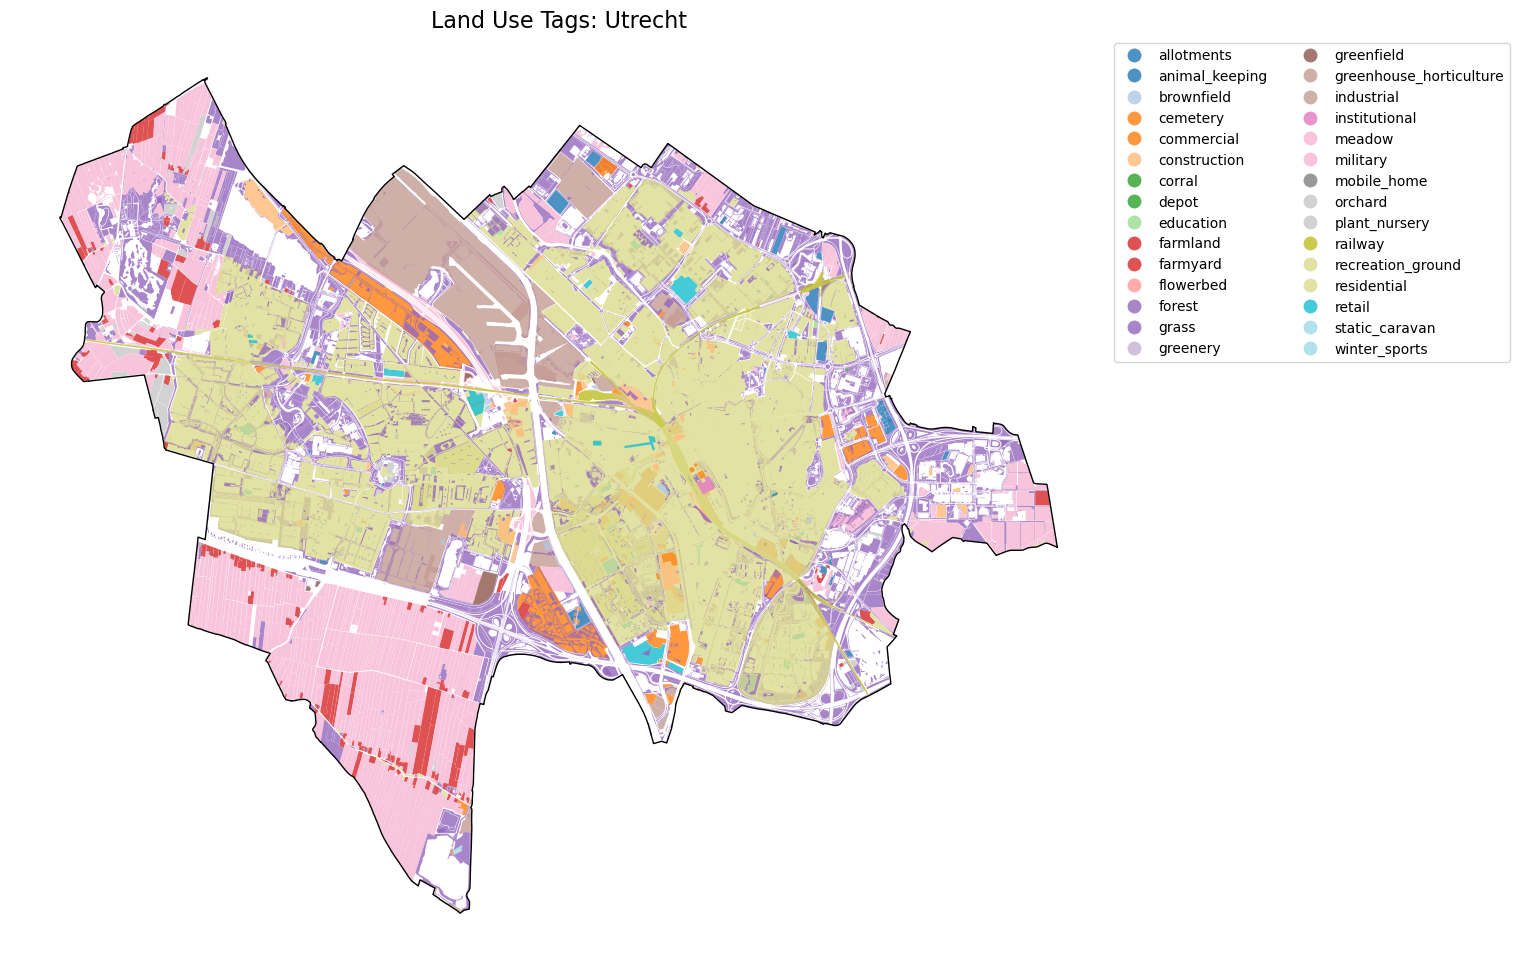


Top 10 Land Use types in Utrecht by Area (Hectares):
landuse
residential     3960.171359
meadow          1579.028803
grass           1400.596813
industrial       689.291636
forest           531.331894
commercial       309.310463
farmland         139.413611
construction     111.514027
railway           97.715036
retail            70.057318
Name: area_ha, dtype: float64
--- Plotting Land Use Map for Rotterdam ---


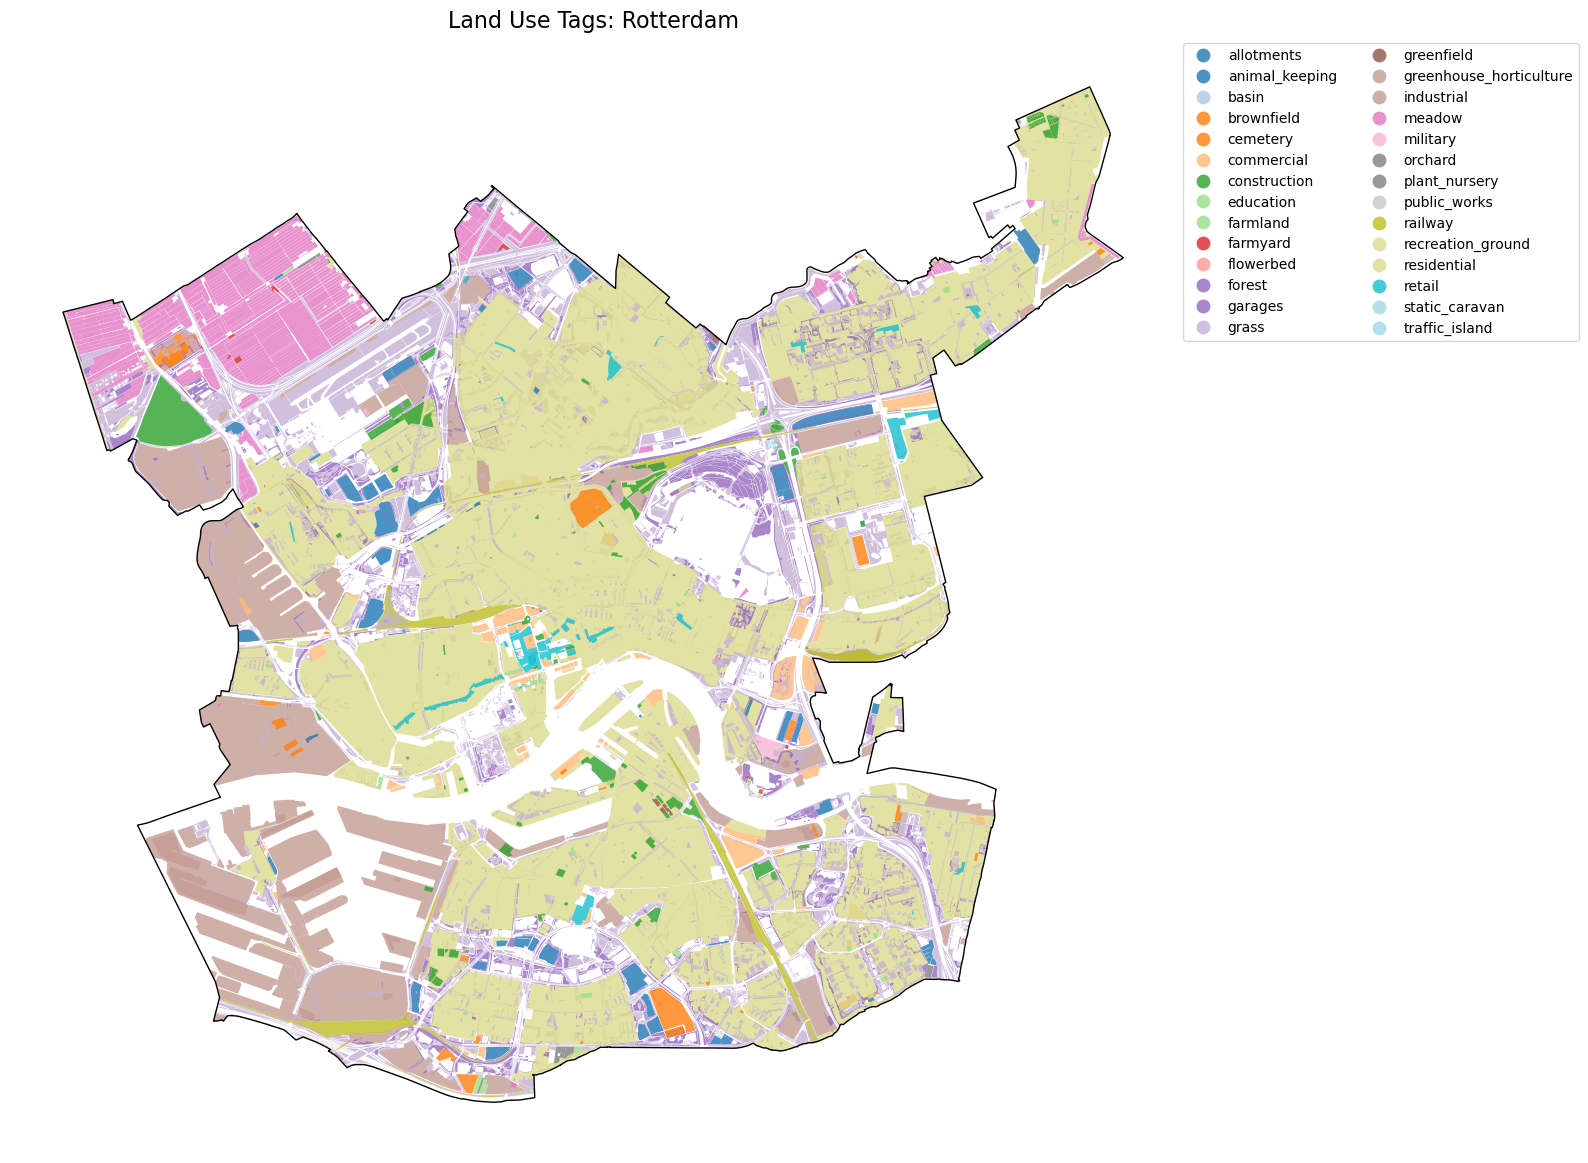


Top 10 Land Use types in Rotterdam by Area (Hectares):
landuse
residential     5616.585211
grass           1676.334565
industrial      1562.645359
forest           559.261919
meadow           552.481833
allotments       186.542193
construction     172.811127
commercial       164.568843
railway          148.479639
cemetery          94.362307
Name: area_ha, dtype: float64


In [9]:
import matplotlib.pyplot as plt

def debug_landuse_mapping(city_name):
    print(f"--- Plotting Land Use Map for {city_name} ---")
    
    # 1. Get City Boundary
    city_gdf = ox.geocode_to_gdf(f"{city_name}, Netherlands").to_crs(epsg=28992)
    city_geom = city_gdf.geometry.iloc[0]
    
    # 2. Get Land Use Data
    osm = OSM(PBF_FILES[city_name])
    landuse = osm.get_landuse()
    
    if landuse is None or landuse.empty:
        print(f"No landuse data found for {city_name}")
        return

    landuse = landuse.to_crs(epsg=28992)
    
    # Fixes
    # 1. Fix invalid geometries (self-intersections, etc)
    landuse['geometry'] = landuse['geometry'].make_valid()
    
    # 2. Filter to intersecting only
    landuse = landuse[landuse.intersects(city_geom)].copy()
    
    # 3. Use buffer(0) to snap topology before intersection
    landuse['geometry'] = landuse.geometry.buffer(0).intersection(city_geom)
    
    # 4. Filter out any resulting empty geometries or slivers
    landuse = landuse[~landuse.is_empty].copy()

    # 5. Remove the random yes
    landuse = landuse[landuse['landuse'] != 'yes'].copy()
    
    
    # 3. Visualization
    fig, ax = plt.subplots(figsize=(15, 12))
    
    # Plot the city boundary as a background
    city_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=1, zorder=2)
    
    # Plot land use
    landuse.plot(
        ax=ax, 
        column='landuse', 
        legend=True, 
        cmap='tab20', 
        alpha=0.8,
        legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left', 'ncol': 2}
    )
    
    ax.set_title(f"Land Use Tags: {city_name}", fontsize=16)
    ax.set_axis_off()
    
    plt.tight_layout()
    plt.show()

    # Stats check
    landuse['area_ha'] = landuse.geometry.area / 10_000
    stats = landuse.groupby('landuse')['area_ha'].sum().sort_values(ascending=False)
    print(f"\nTop 10 Land Use types in {city_name} by Area (Hectares):")
    print(stats.head(10))

# Run the check
debug_landuse_mapping("Utrecht")
debug_landuse_mapping("Rotterdam")

In [ ]:
utrecht_city = get_city_boundary("Utrecht")
rotterdam_city = get_city_boundary("Rotterdam")

cities_gdf = pd.concat([utrecht_city, rotterdam_city], ignore_index=True)

results = []

for _, row in cities_gdf.iterrows():
    city = row["city"]
    geometry = row["geometry"]

    result = calculate_district_cyclability(
        city_name=city,
        district_name=f"{city} (entire city)",
        geometry=geometry
    )
    
    if result is not None:
        results.append(result)

city_level_df = pd.DataFrame(results)




--- Analyzing Utrecht (entire city) in Utrecht ---
--- Analyzing Rotterdam (entire city) in Rotterdam ---


In [45]:
df_cities = city_level_df

In [ ]:

def minmax_with_reference(series, ref_series):
    return (series - ref_series.min()) / (ref_series.max() - ref_series.min())

# Network connectivity subcomponents
for col in ["Separation_Ratio", "Low_Stress_Connectivity"]:
    df_cities[f"{col}_norm"] = minmax_with_reference(
        df_cities[col],
        df[col]
    )

df_cities["Net_Connectivity"] = (
    0.5 * df_cities["Separation_Ratio_norm"] +
    0.5 * df_cities["Low_Stress_Connectivity_norm"]
)

# Final normalization
for col in ["Net_Connectivity", "Land_Use_Diversity", "Dest_Accessibility"]:
    df_cities[f"{col}_norm"] = minmax_with_reference(
        df_cities[col],
        df[col]
    )

df_cities["Cyclability_Index"] = (
    0.4 * df_cities["Net_Connectivity_norm"] +
    0.3 * df_cities["Land_Use_Diversity_norm"] +
    0.3 * df_cities["Dest_Accessibility_norm"]
)





In [2]:
# --- EXECUTION ---

results_list = []
for _, row in all_neighbourhoods_gdf.iterrows():
    result = calculate_district_cyclability(row['city'], row['name'], row['geometry'])
    results_list.append(result)

# Create DataFrame
df = pd.DataFrame([r for r in results_list if r])

# Network connectivity part
for col in ["Separation_Ratio", "Low_Stress_Connectivity"]:
    df[f"{col}_norm"] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

df['Net_Connectivity'] = (df["Separation_Ratio_norm"]*0.5 + df["Low_Stress_Connectivity_norm"]* 0.5)


# Normalization
for col in ["Net_Connectivity", "Land_Use_Diversity", "Dest_Accessibility"]:
    df[f"{col}_norm"] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

df['Cyclability_Index'] = (df['Net_Connectivity_norm']*0.4 + 
                           df['Land_Use_Diversity_norm']*0.3 + 
                           df['Dest_Accessibility_norm']*0.3)



--- Analyzing West in Utrecht ---
--- Analyzing Binnenstad in Utrecht ---
--- Analyzing Zuidwest in Utrecht ---
--- Analyzing Zuid in Utrecht ---
--- Analyzing Oost in Utrecht ---
--- Analyzing Noordoost in Utrecht ---
--- Analyzing Overvecht in Utrecht ---
--- Analyzing Noordwest in Utrecht ---
--- Analyzing Leidsche Rijn in Utrecht ---
--- Analyzing Vleuten - De Meern in Utrecht ---
--- Analyzing IJsselmonde in Rotterdam ---
--- Analyzing Delfshaven in Rotterdam ---
--- Analyzing Stadsdriehoek in Rotterdam ---
--- Analyzing Centrum in Rotterdam ---
--- Analyzing Noord in Rotterdam ---
--- Analyzing Feijenoord in Rotterdam ---
--- Analyzing Charlois in Rotterdam ---
--- Analyzing Prins Alexander in Rotterdam ---
--- Analyzing Overschie in Rotterdam ---
--- Analyzing Hillegersberg-Schiebroek in Rotterdam ---
--- Analyzing Rotterdam (unassigned 1) in Rotterdam ---
--- Analyzing Rotterdam (unassigned 2) in Rotterdam ---


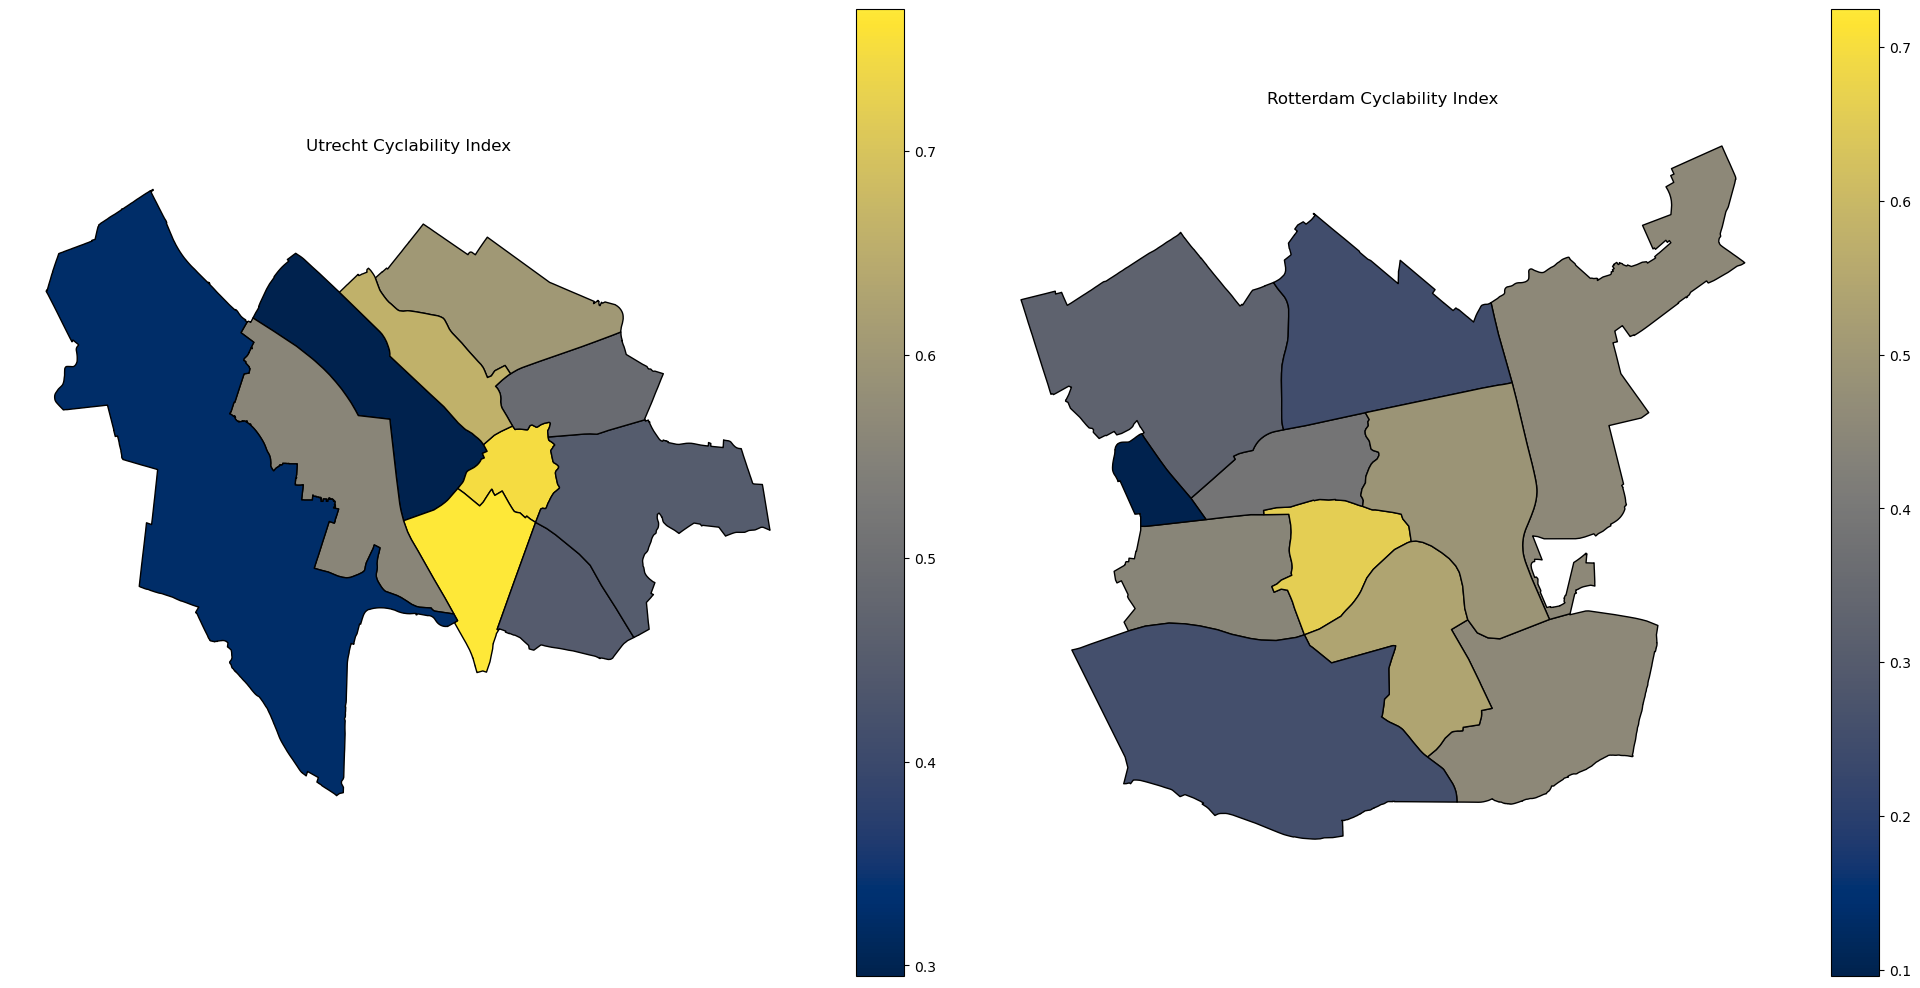

                    District       City  Total_Density  \
2                   Zuidwest    Utrecht      27.113960   
1                 Binnenstad    Utrecht      31.497984   
12             Stadsdriehoek  Rotterdam      35.749850   
7                  Noordwest    Utrecht      28.284094   
13                   Centrum  Rotterdam      30.693196   
6                  Overvecht    Utrecht      22.277508   
8              Leidsche Rijn    Utrecht      24.528899   
15                Feijenoord  Rotterdam      25.974668   
5                  Noordoost    Utrecht      23.778888   
21  Rotterdam (unassigned 2)  Rotterdam      19.533127   
10               IJsselmonde  Rotterdam      23.341952   
17           Prins Alexander  Rotterdam      25.380394   
4                       Oost    Utrecht      19.040119   
3                       Zuid    Utrecht      22.314053   
11                Delfshaven  Rotterdam      24.295439   
14                     Noord  Rotterdam      27.952669   
18            

In [4]:
# --- VISUALIZATION (Side-by-Side Map) ---
map_gdf = all_neighbourhoods_gdf.merge(df, left_on=["name", "city"], right_on=["District", "City"])
map_gdf = map_gdf.to_crs(epsg=28992)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot Utrecht
map_gdf[map_gdf['city'] == 'Utrecht'].plot(column='Cyclability_Index', ax=ax1, legend=True, cmap='cividis', edgecolor='black')
ax1.set_title("Utrecht Cyclability Index")
ax1.axis("off")

# Plot Rotterdam
map_gdf[map_gdf['city'] == 'Rotterdam'].plot(column='Cyclability_Index', ax=ax2, legend=True, cmap='cividis', edgecolor='black')
ax2.set_title("Rotterdam Cyclability Index")
ax2.axis("off")

plt.tight_layout()
plt.show()

print(df.sort_values('Cyclability_Index', ascending=False))

In [3]:
df.drop(
    df[df["District"] == "Stadsdriehoek"].index,
    inplace=True
)
df

District       City  Total_Density  \
0                       West    Utrecht      18.979026   
1                 Binnenstad    Utrecht      31.497984   
2                   Zuidwest    Utrecht      27.113960   
3                       Zuid    Utrecht      22.314053   
4                       Oost    Utrecht      19.040119   
5                  Noordoost    Utrecht      23.778888   
6                  Overvecht    Utrecht      22.277508   
7                  Noordwest    Utrecht      28.284094   
8              Leidsche Rijn    Utrecht      24.528899   
9         Vleuten - De Meern    Utrecht      12.530835   
10               IJsselmonde  Rotterdam      23.341952   
11                Delfshaven  Rotterdam      24.295439   
13                   Centrum  Rotterdam      30.693196   
14                     Noord  Rotterdam      27.952669   
15                Feijenoord  Rotterdam      25.974668   
16                  Charlois  Rotterdam      17.668636   
17           Prins Alexander  Rotterdam      25.380394   
18                 Overschie  Rotterdam      13.299594   
19  Hillegersberg-Schiebroek  Rotterdam      16.726761   
20  Rotterdam (unassigned 1)  Rotterdam      23.201417   
21  Rotterdam (unassigned 2)  Rotterdam      19.533127   

    Low_Stress_Connectivity  Separation_Ratio  Land_Use_Diversity  \
0                  9.741914          0.188300            1.301489   
1                 19.063382          0.158921            1.864183   
2                 15.744303          0.241607            1.560480   
3                 14.102179          0.179078            1.224181   
4                  8.622171          0.182659            1.784607   
5                 17.142385          0.185497            1.168891   
6                 10.745998          0.254222            1.682158   
7                 20.883767          0.221017            1.136866   
8                 15.324571          0.221250            1.575051   
9                  6.670971          0.207790            1.675172   
10                13.619043          0.209922            1.418149   
11                15.720823          0.210405            1.136718   
13                14.170824          0.223590            1.372138   
14                17.205852          0.188950            1.047136   
15                17.650726          0.186204            0.842126   
16                 8.509820          0.181294            1.539153   
17                16.093430          0.217366            1.172153   
18                 5.531109          0.211177            1.793145   
19                10.663288          0.197438            1.135355   
20                 5.980742          0.219820            0.444593   
21                10.633626          0.228643            1.673170   

    Dest_Accessibility  Separation_Ratio_norm  Low_Stress_Connectivity_norm  \
0           264.427696               0.308270                      0.274272   
1          1096.806553               0.000000                      0.881429   
2           648.466427               0.867627                      0.665239   
3           645.022134               0.211506                      0.558279   
4           603.376898               0.249080                      0.201337   
5           531.798181               0.278864                      0.756304   
6           192.193774               1.000000                      0.339673   
7           436.729978               0.651579                      1.000000   
8           169.829164               0.654020                      0.637900   
9            81.329594               0.512782                      0.074245   
10          182.347947               0.535151                      0.526810   
11          189.541882               0.540225                      0.663710   
13          732.647670               0.678573                      0.562750   
14          206.420662               0.315090                      0.760438   
15          900.445181               0.

In [4]:
district_ranking = (
    df[['District', 'City', 'Cyclability_Index', 'Net_Connectivity_norm', 'Land_Use_Diversity_norm', 'Dest_Accessibility_norm', 'Separation_Ratio_norm', 'Low_Stress_Connectivity_norm']]
    .sort_values('Cyclability_Index', ascending=False)
    .reset_index(drop=True)
)

district_ranking


District       City  Cyclability_Index  \
0                   Zuidwest    Utrecht           0.769609   
1                 Binnenstad    Utrecht           0.748070   
2                  Noordwest    Utrecht           0.658764   
3                    Centrum  Rotterdam           0.658354   
4                  Overvecht    Utrecht           0.602496   
5              Leidsche Rijn    Utrecht           0.557886   
6                 Feijenoord  Rotterdam           0.539842   
7                  Noordoost    Utrecht           0.490902   
8   Rotterdam (unassigned 2)  Rotterdam           0.489425   
9                IJsselmonde  Rotterdam           0.453061   
10           Prins Alexander  Rotterdam           0.452508   
11                      Oost    Utrecht           0.450074   
12                      Zuid    Utrecht           0.447943   
13                Delfshaven  Rotterdam           0.442073   
14                     Noord  Rotterdam           0.385932   
15                 Overschie  Rotterdam           0.324093   
16        Vleuten - De Meern    Utrecht           0.323318   
17                      West    Utrecht           0.294900   
18                  Charlois  Rotterdam           0.257747   
19  Hillegersberg-Schiebroek  Rotterdam           0.249638   
20  Rotterdam (unassigned 1)  Rotterdam           0.095884   

    Net_Connectivity_norm  Land_Use_Diversity_norm  Dest_Accessibility_norm  \
0                0.902918                 0.786062                 0.575411   
1                0.370174                 1.000000                 1.000000   
2                1.000000                 0.487656                 0.374891   
3                0.664495                 0.653389                 0.655133   
4                0.744925                 0.871776                 0.143309   
5                0.705872                 0.796327                 0.122130   
6                0.529048                 0.280033                 0.814041   
7                0.495901                 0.510216                 0.464923   
8                0.519437                 0.865444                 0.073389   
9                0.517813                 0.685800                 0.133985   
10               0.713498                 0.512514                 0.044516   
11               0.017695                 0.943944                 0.532710   
12               0.278873                 0.549164                 0.572149   
13               0.633919                 0.487553                 0.140798   
14               0.528908                 0.424448                 0.156783   
15               0.097763                 0.949959                 0.000000   
16               0.129414                 0.866855                 0.038318   
17               0.125746                 0.603622                 0.211717   
18               0.000000                 0.771039                 0.088119   
19               0.253242                 0.486593                 0.007880   
20               0.195882                 0.000000                 0.058438   

    Separation_Ratio_norm  Low_Stress_Connectivity_norm  
0                0.867627                      0.665239  
1                0.000000                      0.881429  
2                0.651579                      1.000000  
3                0.678573                      0.562750  
4                1.000000                      0.339673  
5                0.654020                      0.637900  
6                0.286285                      0.789415  
7                0.278864                      0.756304  
8                0.731593                      0.332354  
9                0.535151                      0.526810  
10               0.613265                      0.687980  
11               0.249080                      0.201337  
12               0.211506                      0.558279  
13               0.540225                      0.663710  
14               0.315090                     

In [48]:
city_avg = (
    df_cities.groupby('City')['Cyclability_Index']
      .agg(['mean', 'std', 'min', 'max'])
      .round(3)
)

city_avg


mean  std    min    max
City                               
Rotterdam  0.423  NaN  0.423  0.423
Utrecht    0.489  NaN  0.489  0.489

In [28]:
component_avgs = (
    df.groupby('City')[
        [
            'Net_Connectivity_norm',
            'Land_Use_Diversity_norm',
            'Dest_Accessibility_norm'
        ]
    ]
    .mean()
    .round(3)
)

component_avgs


Net_Connectivity_norm  Land_Use_Diversity_norm  \
City                                                        
Rotterdam                  0.423                    0.556   
Utrecht                    0.477                    0.742   

           Dest_Accessibility_norm  
City                                
Rotterdam                    0.198  
Utrecht                      0.404

--- Generating City-Wide Maps for Utrecht ---


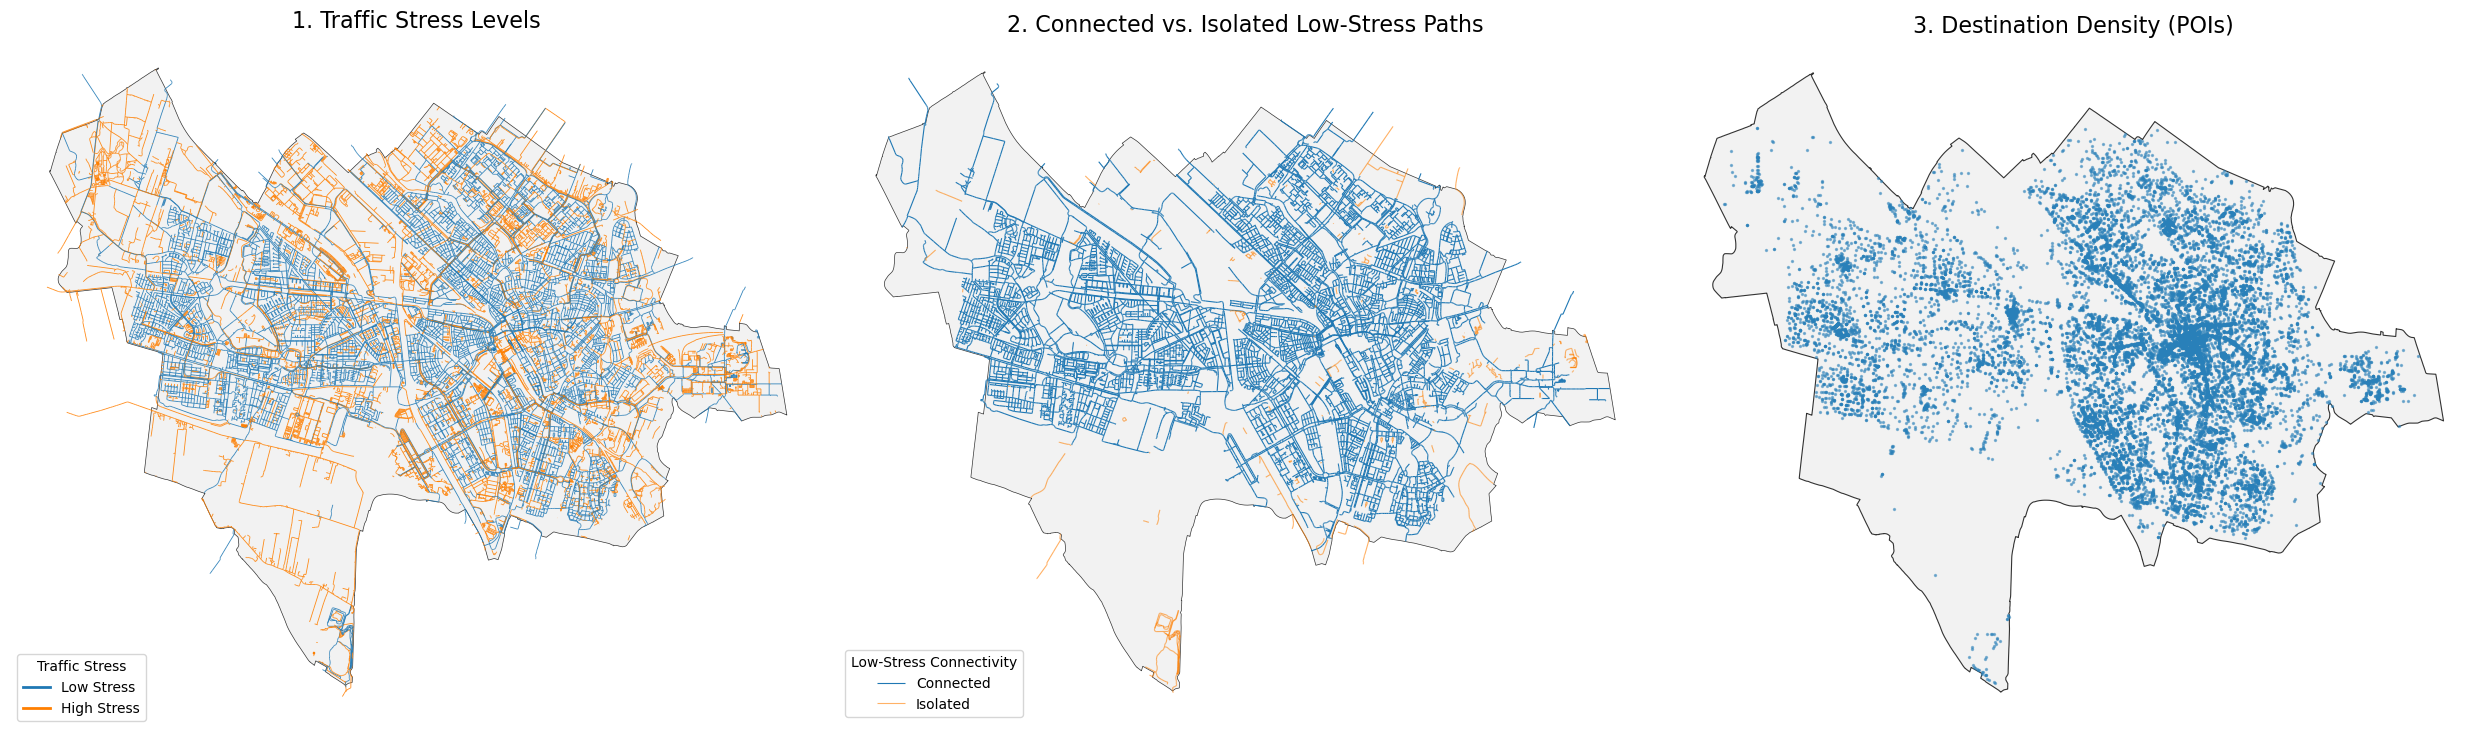

--- Generating City-Wide Maps for Rotterdam ---


c:\Users\David\anaconda3\envs\geospatial\Lib\site-packages\pyrosm\pois.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gdf = prepare_geodataframe(
c:\Users\David\anaconda3\envs\geospatial\Lib\site-packages\pyrosm\pois.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gdf = prepare_geodataframe(
c:\Users\David\anaconda3\envs\geospatial\Lib\site-packages\pyrosm\pois.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

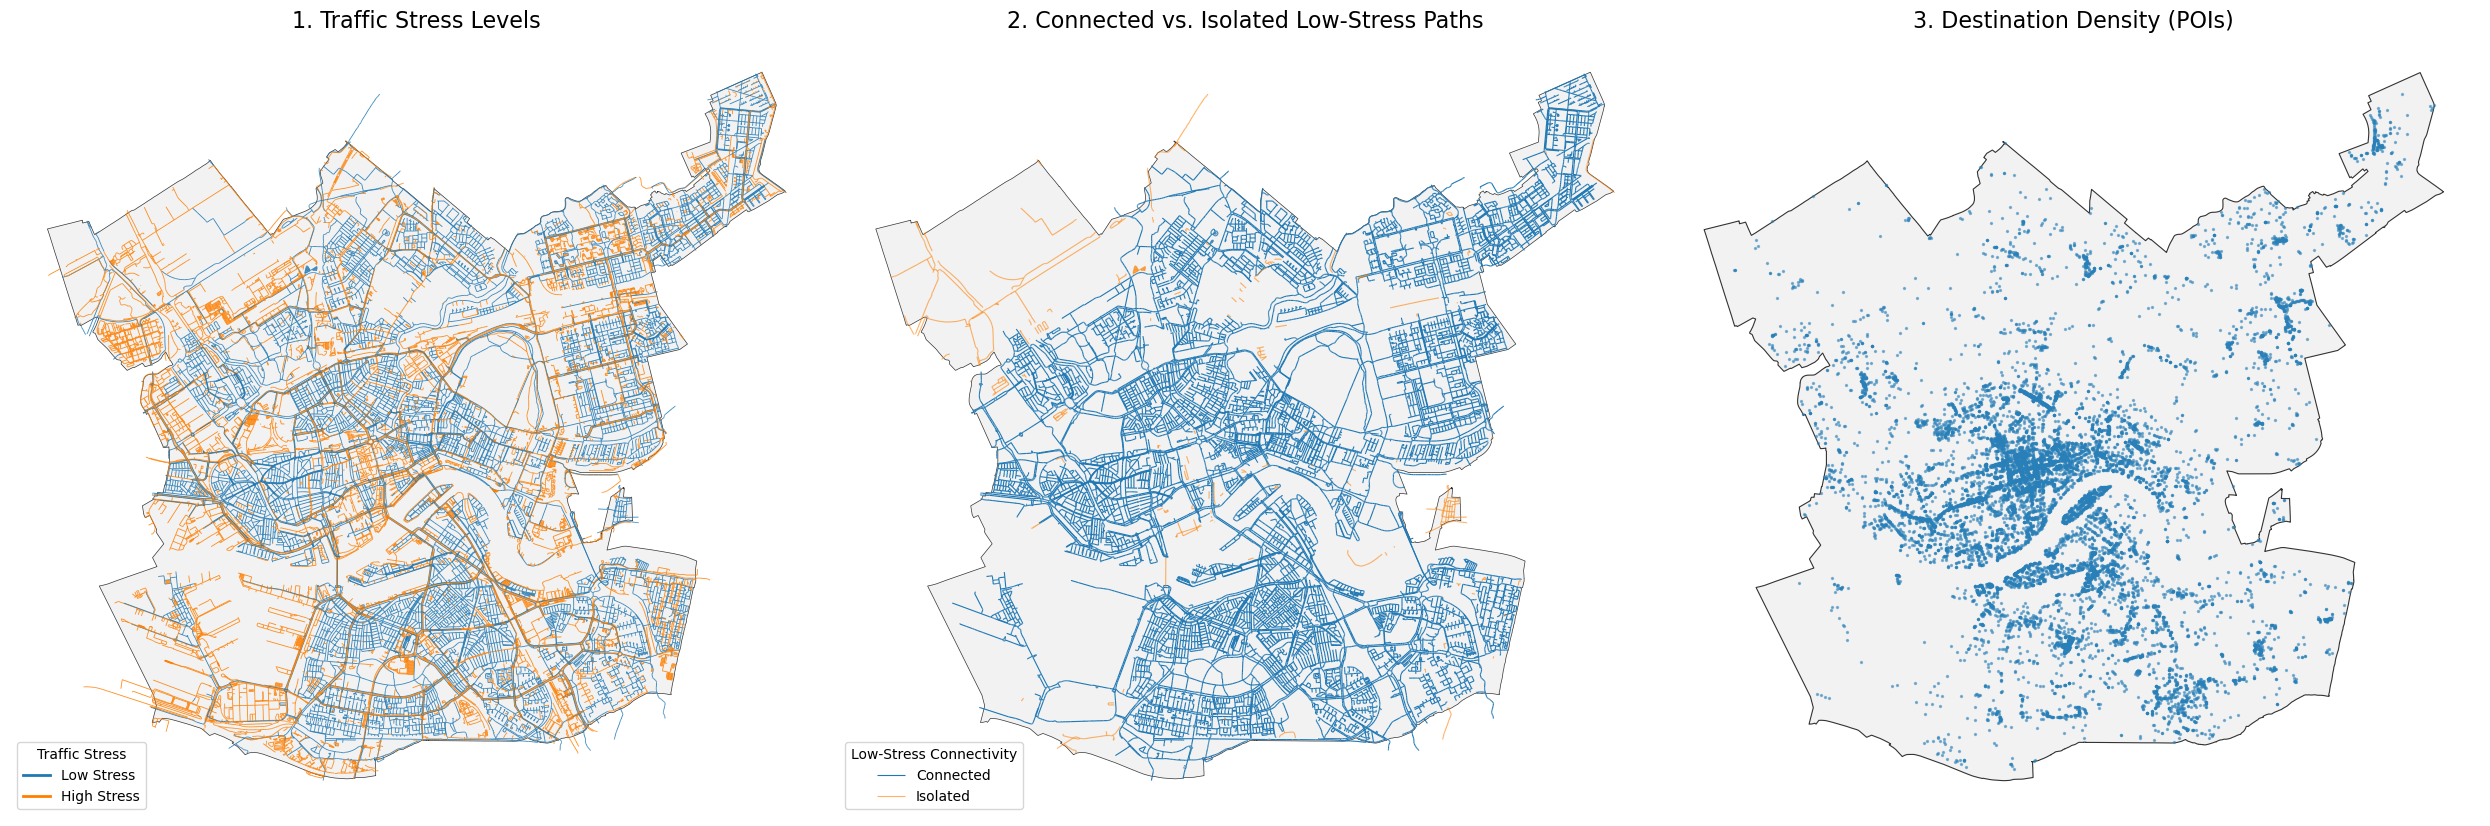

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
from matplotlib.lines import Line2D

def visualize_city_cyclability(city_name):
    print(f"--- Generating City-Wide Maps for {city_name} ---")
    
    # 1. Load City Boundary and OSM Data
    city_gdf = ox.geocode_to_gdf(f"{city_name}, Netherlands").to_crs(epsg=28992)
    city_geom = city_gdf.geometry.iloc[0]
    
    osm = OSM(PBF_FILES[city_name])
    
    # Get Network and POIs (Landuse excluded here as requested)
    net = osm.get_network(network_type="cycling").to_crs(epsg=28992)
    net = net[net.intersects(city_geom)].copy()
    
    pois = osm.get_pois().to_crs(epsg=28992)
    pois = pois[pois.intersects(city_geom)].copy()
    pois = pois[pois.geometry.type == 'Point']


    # 2. Process Network Stress (Mekuria/Schepers logic)
    separated_tags = ['track', 'opposite_track', 'separate']
    is_sep = (net['cycleway'].isin(separated_tags)) | (net['highway'] == 'cycleway') | (net['bicycle'] == 'designated')
    
    def is_low_speed(val):
        try: return float(val) <= 30
        except: return False
            
    is_low = net['maxspeed'].apply(is_low_speed) | (net['highway'] == 'living_street')
    net['stress_cat'] = ['Low Stress' if s else 'High Stress' for s in (is_sep | is_low)]
    
    # 3. Connectivity Analysis (The Giant Component)
    low_stress_net = net[net['stress_cat'] == 'Low Stress'].copy().explode(index_parts=False)
    
    G = nx.Graph()
    for _, row in low_stress_net.iterrows():
        coords = list(row.geometry.coords)
        for i in range(len(coords)-1):
            u, v = (round(coords[i][0], 1), round(coords[i][1], 1)), (round(coords[i+1][0], 1), round(coords[i+1][1], 1))
            G.add_edge(u, v)
    
    if len(G) > 0:
        largest_cc_nodes = max(nx.connected_components(G), key=len)
        def check_connectivity(geom):
            pts = [(round(p[0], 1), round(p[1], 1)) for p in geom.coords]
            return any(pt in largest_cc_nodes for pt in pts)
        low_stress_net['connected'] = low_stress_net.geometry.apply(check_connectivity)
    
    # 4. Plotting
    fig, axes = plt.subplots(1, 3, figsize=(25, 10))
    fig.patch.set_facecolor('white')

    stress_colors = {
    'Low Stress': '#1f78b4',   # blue
    'High Stress': '#ff7f00'   # orange
    }

    city_gdf.plot(ax=axes[0], color="#f2f2f2", edgecolor='#333333', linewidth=0.5)

    net.plot(
        ax=axes[0],
        color=net['stress_cat'].map(stress_colors),
        linewidth=0.6,
        alpha=0.9
    )

    legend_elements = [
        Line2D([0], [0], color='#1f78b4', lw=2, label='Low Stress'),
        Line2D([0], [0], color='#ff7f00', lw=2, label='High Stress')
    ]

    axes[0].legend(
        handles=legend_elements,
        loc='lower left',
        frameon=True,
        title='Traffic Stress'
    )

    axes[0].set_title("1. Traffic Stress Levels", fontsize=16)



    # MAP 2: Connectivity (Broken Network)
    city_gdf.plot(ax=axes[1], color='#f2f2f2', edgecolor='#333333', linewidth=0.5)
    if not low_stress_net.empty:
        low_stress_net[low_stress_net['connected']].plot(ax=axes[1], color='#1f78b4', linewidth=0.8, label='Connected')
        low_stress_net[~low_stress_net['connected']].plot(ax=axes[1], color='#ff7f00', linewidth=0.8, label='Isolated', alpha=0.6)
    axes[1].set_title("2. Connected vs. Isolated Low-Stress Paths", fontsize=16)
    axes[1].legend(
    loc='lower left',
    frameon=True,
    title='Low-Stress Connectivity'
    )

    # MAP 3: Destination Accessibility (Functional Utility)
    # We use a dark background or distinct boundary to make the dots pop
    city_gdf.plot(ax=axes[2], color='#f2f2f2', edgecolor='#333333', linewidth=0.8)
    if not pois.empty:
        # Using a small 'x' or dot to show density clusters
        pois.plot(ax=axes[2], markersize=2, color='#2980b9', alpha=0.5)
    axes[2].set_title("3. Destination Density (POIs)", fontsize=16)

    for ax in axes:
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

# Run for both cities
visualize_city_cyclability("Utrecht")
visualize_city_cyclability("Rotterdam")

C:\Users\David\AppData\Local\Temp\ipykernel_12420\4267890389.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('cividis')


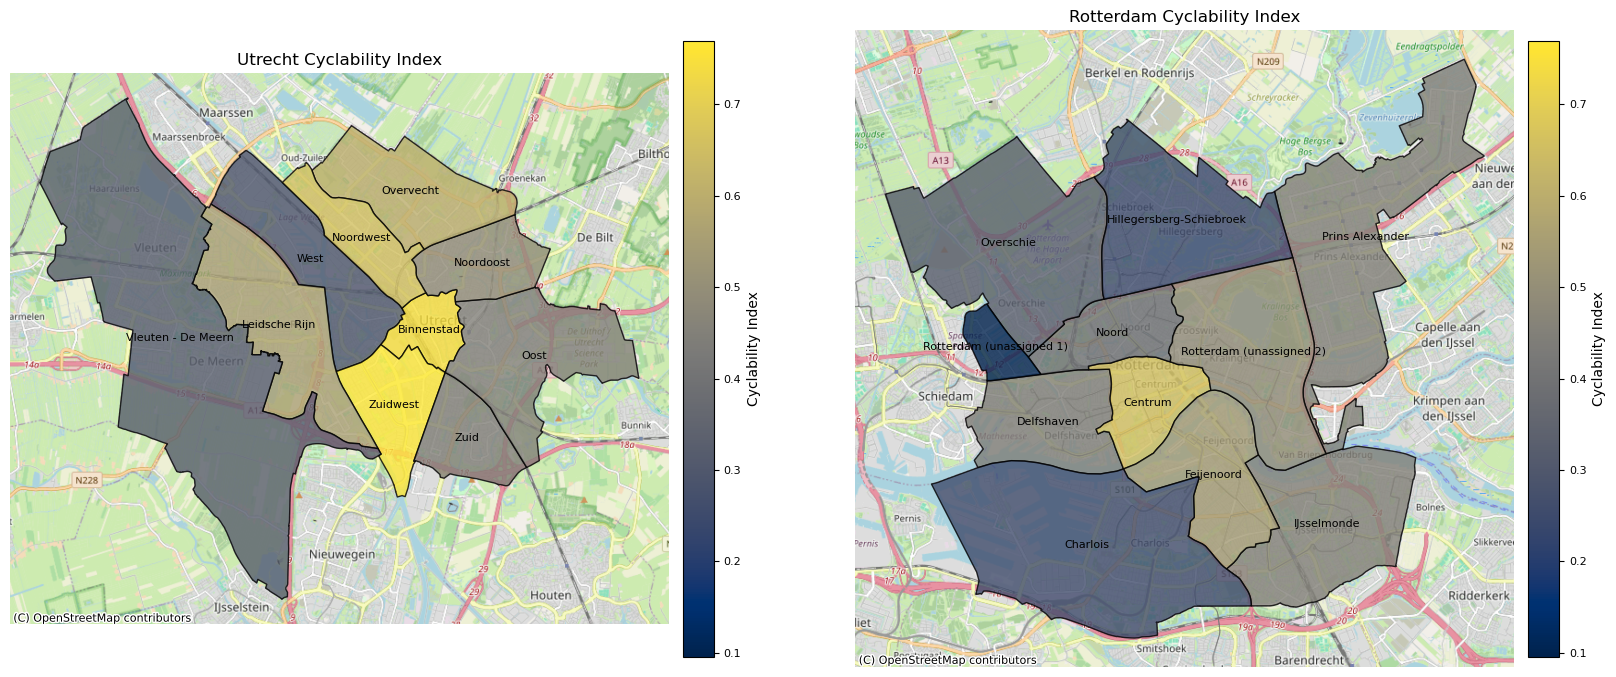

: 

In [ ]:
import contextily as ctx

# Merge and reproject for basemap compatibility
map_gdf = all_neighbourhoods_gdf.merge(
    df, left_on=["name", "city"], right_on=["District", "City"]
).to_crs(epsg=3857)

vmin = map_gdf["Cyclability_Index"].min()
vmax = map_gdf["Cyclability_Index"].max()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# --- Utrecht ---
utrecht = map_gdf[map_gdf['city'] == 'Utrecht']
utrecht.plot(
    column='Cyclability_Index',
    ax=ax1,
    legend=False,
    cmap='cividis',
    edgecolor='black',
    alpha=0.8,
    vmin=vmin,
    vmax=vmax
)
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)
ax1.set_title("Utrecht Cyclability Index")
ax1.axis("off")

# Add district names for Utrecht
for idx, row in utrecht.iterrows():
    ax1.annotate(text=row['District'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 ha='center', va='center', fontsize=8, color='black')


# --- Rotterdam ---
rotterdam = map_gdf[map_gdf['city'] == 'Rotterdam']
rotterdam.plot(
    column='Cyclability_Index',
    ax=ax2,
    legend=False,
    cmap='cividis',
    edgecolor='black',
    alpha=0.8,
    vmin=vmin,
    vmax=vmax
)
ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik)
ax2.set_title("Rotterdam Cyclability Index")
ax2.axis("off")

# Add district names for Rotterdam
for idx, row in rotterdam.iterrows():
    ax2.annotate(text=row['District'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 ha='center', va='center', fontsize=8, color='black')
    
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = mpl.cm.get_cmap('cividis')

# --- Colorbar for Utrecht ---
sm1 = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm1._A = []

cbar1 = fig.colorbar(
    sm1,
    ax=ax1,
    fraction=0.045,   # width
    pad=0.02,
    shrink=0.8        # height ~ map height
)
cbar1.set_label("Cyclability Index", fontsize=10)
cbar1.ax.tick_params(labelsize=8)

# --- Colorbar for Rotterdam ---
sm2 = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm2._A = []

cbar2 = fig.colorbar(
    sm2,
    ax=ax2,
    fraction=0.045,
    pad=0.02,
    shrink=0.8
)
cbar2.set_label("Cyclability Index", fontsize=10)
cbar2.ax.tick_params(labelsize=8)



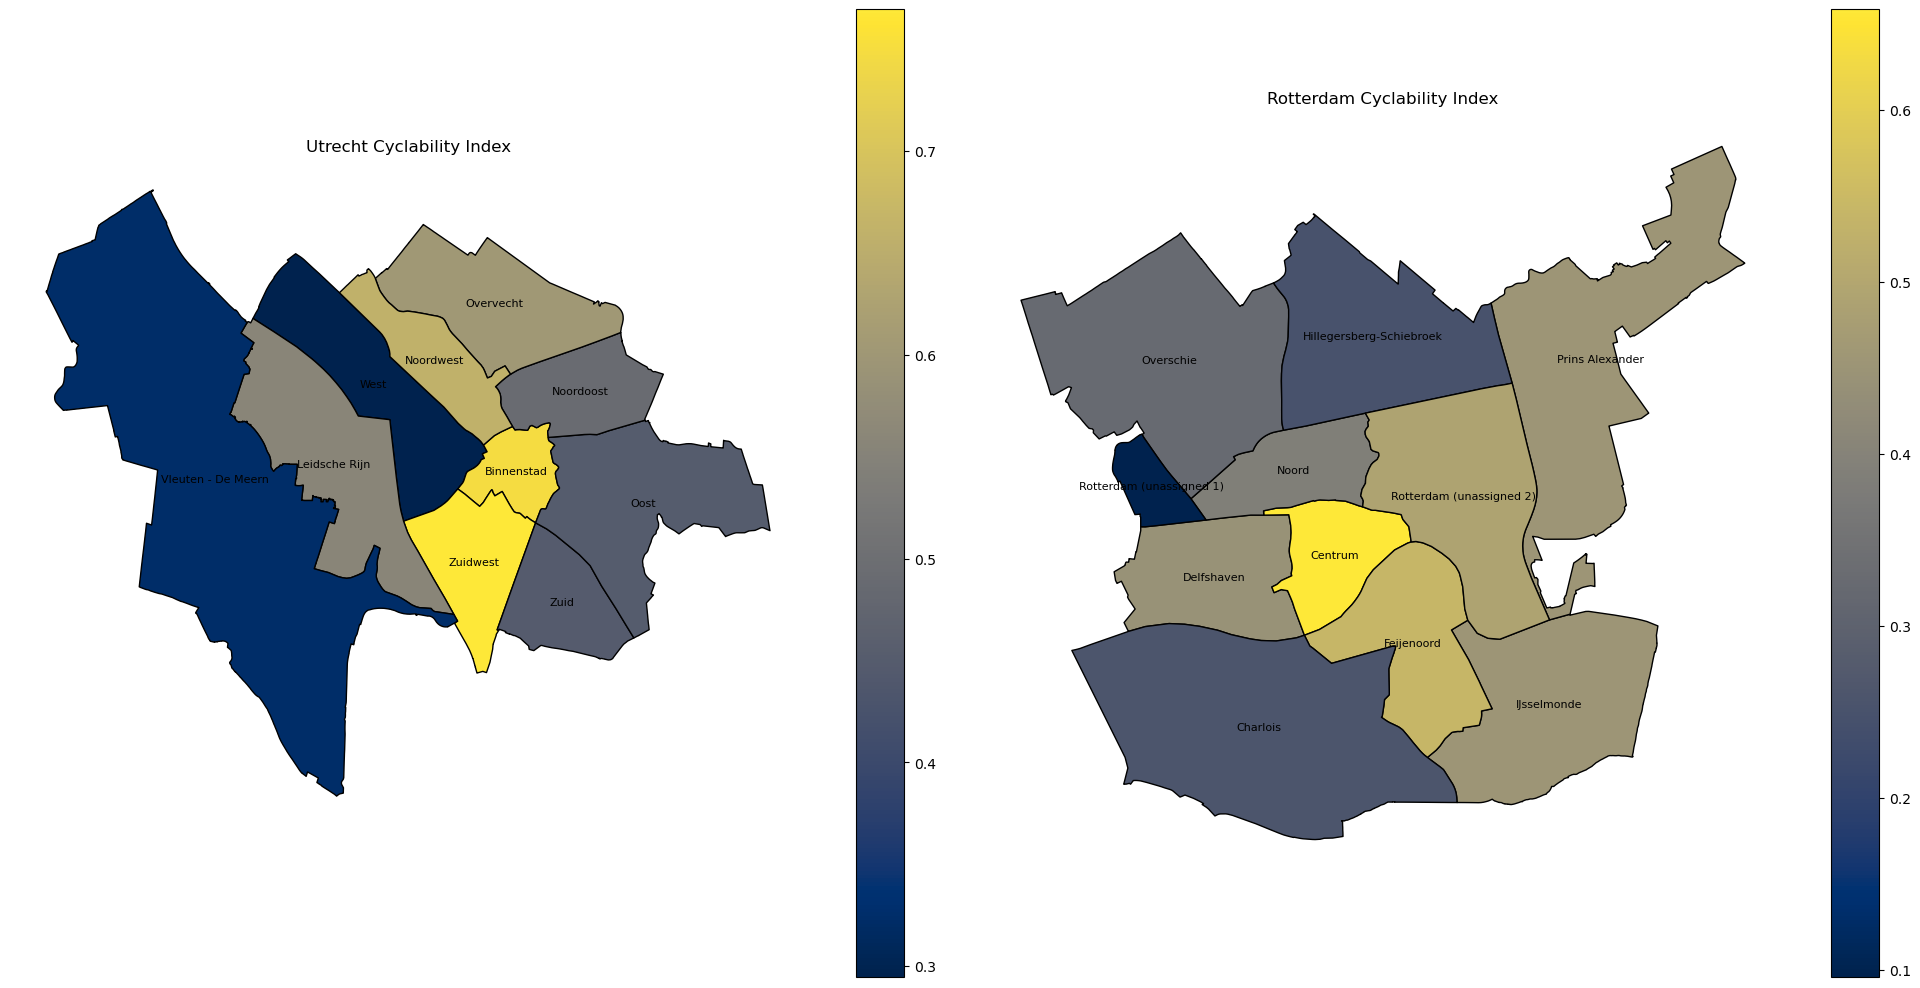

                    District       City  Total_Density  \
2                   Zuidwest    Utrecht      27.113960   
1                 Binnenstad    Utrecht      31.497984   
7                  Noordwest    Utrecht      28.284094   
13                   Centrum  Rotterdam      30.693196   
6                  Overvecht    Utrecht      22.277508   
8              Leidsche Rijn    Utrecht      24.528899   
15                Feijenoord  Rotterdam      25.974668   
5                  Noordoost    Utrecht      23.778888   
21  Rotterdam (unassigned 2)  Rotterdam      19.533127   
10               IJsselmonde  Rotterdam      23.341952   
17           Prins Alexander  Rotterdam      25.380394   
4                       Oost    Utrecht      19.040119   
3                       Zuid    Utrecht      22.314053   
11                Delfshaven  Rotterdam      24.295439   
14                     Noord  Rotterdam      27.952669   
18                 Overschie  Rotterdam      13.299594   
9         Vleu

In [8]:
# --- VISUALIZATION (Side-by-Side Map) ---
map_gdf = all_neighbourhoods_gdf.merge(df, left_on=["name", "city"], right_on=["District", "City"])
map_gdf = map_gdf.to_crs(epsg=28992)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot Utrecht
utrecht_gdf = map_gdf[map_gdf['city'] == 'Utrecht']
utrecht_gdf.plot(column='Cyclability_Index', ax=ax1, legend=True, cmap='cividis', edgecolor='black')
ax1.set_title("Utrecht Cyclability Index")
ax1.axis("off")

# Add district names for Utrecht
for idx, row in utrecht_gdf.iterrows():
    ax1.annotate(text=row['District'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 ha='center', va='center', fontsize=8, color='black')

# Plot Rotterdam
rotterdam_gdf = map_gdf[map_gdf['city'] == 'Rotterdam']
rotterdam_gdf.plot(column='Cyclability_Index', ax=ax2, legend=True, cmap='cividis', edgecolor='black')
ax2.set_title("Rotterdam Cyclability Index")
ax2.axis("off")

# Add district names for Rotterdam
for idx, row in rotterdam_gdf.iterrows():
    ax2.annotate(text=row['District'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 ha='center', va='center', fontsize=8, color='black')

plt.tight_layout()
plt.show()

print(df.sort_values('Cyclability_Index', ascending=False))
